# Decision Boundary Visualization

This notebook demonstrates decision boundaries for logistic regression:

1. Linear decision boundaries
2. Non-linear boundaries with polynomial features
3. Effect of regularization on boundaries

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles, make_moons, make_classification
from sklearn.preprocessing import PolynomialFeatures
import sys
sys.path.append('..')
from utils import sigmoid, compute_cost, compute_gradient, gradient_descent, predict

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)
np.random.seed(42)


---
## Scenario 1: Linearly Separable Data

When data is linearly separable, a straight line can perfectly separate the classes.

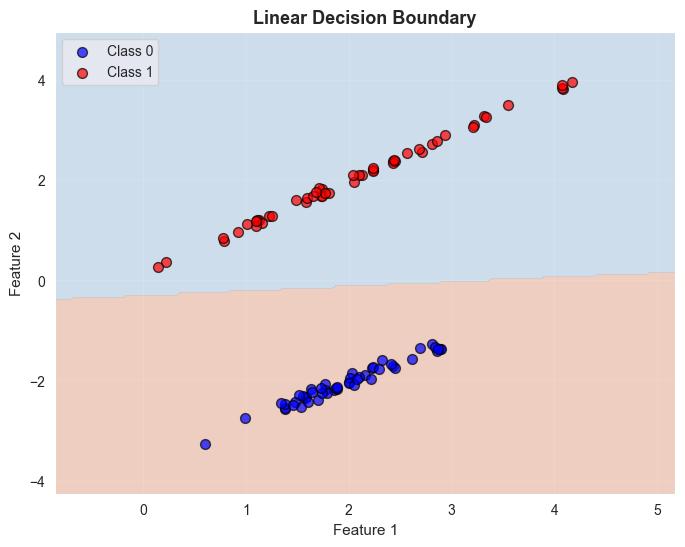

In [2]:
# Generate linearly separable data
X_linear, y_linear = make_classification(
    n_samples=100, n_features=2, n_informative=2,
    n_redundant=0, n_clusters_per_class=1,
    random_state=42, class_sep=2.0
)
y_linear = y_linear.reshape(-1, 1)

# Add bias and train
X_linear_b = np.c_[np.ones((X_linear.shape[0], 1)), X_linear]
theta_linear = np.zeros((3, 1))
theta_linear, _ = gradient_descent(X_linear_b, y_linear, theta_linear, 
                                  learning_rate=0.1, n_iterations=5000, verbose=False)

# Plot
def plot_decision_boundary(X, y, theta, title):
    # Create mesh
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                          np.linspace(x2_min, x2_max, 200))
    
    # Predict for mesh
    if theta.shape[0] == 3:  # Linear (bias + 2 features)
        mesh_points = np.c_[np.ones(xx1.ravel().shape[0]), xx1.ravel(), xx2.ravel()]
    else:  # Polynomial features
        mesh_points = create_poly_features(np.c_[xx1.ravel(), xx2.ravel()], degree=2)
    
    Z = predict(mesh_points, theta)
    Z = Z.reshape(xx1.shape)
    
    # Plot
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap='RdYlBu', levels=[0, 0.5, 1])
    plt.scatter(X[y.ravel() == 0, 0], X[y.ravel() == 0, 1],
               c='blue', label='Class 0', alpha=0.7, edgecolors='k', s=50)
    plt.scatter(X[y.ravel() == 1, 0], X[y.ravel() == 1, 1],
               c='red', label='Class 1', alpha=0.7, edgecolors='k', s=50)
    plt.xlabel('Feature 1', fontsize=11)
    plt.ylabel('Feature 2', fontsize=11)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.figure(figsize=(8, 6))
plot_decision_boundary(X_linear, y_linear, theta_linear, 'Linear Decision Boundary')
plt.show()


---
## Scenario 2: Non-Linearly Separable Data (Circles)

When data forms circles, a linear boundary fails. We need **polynomial features**.

Circles dataset: (200, 2)
Class distribution: (array([0, 1]), array([100, 100]))


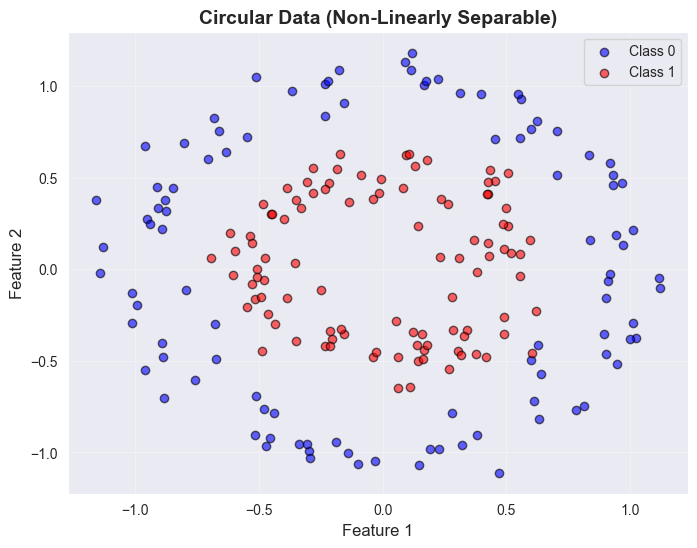

In [3]:
# Generate circular data
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=42)
y_circles = y_circles.reshape(-1, 1)

print(f'Circles dataset: {X_circles.shape}')
print(f'Class distribution: {np.unique(y_circles, return_counts=True)}')

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_circles[y_circles.ravel() == 0, 0], X_circles[y_circles.ravel() == 0, 1],
           c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(X_circles[y_circles.ravel() == 1, 0], X_circles[y_circles.ravel() == 1, 1],
           c='red', label='Class 1', alpha=0.6, edgecolors='k')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Circular Data (Non-Linearly Separable)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Train with Linear Features (Will Fail)

Linear Model Accuracy: 50.50%


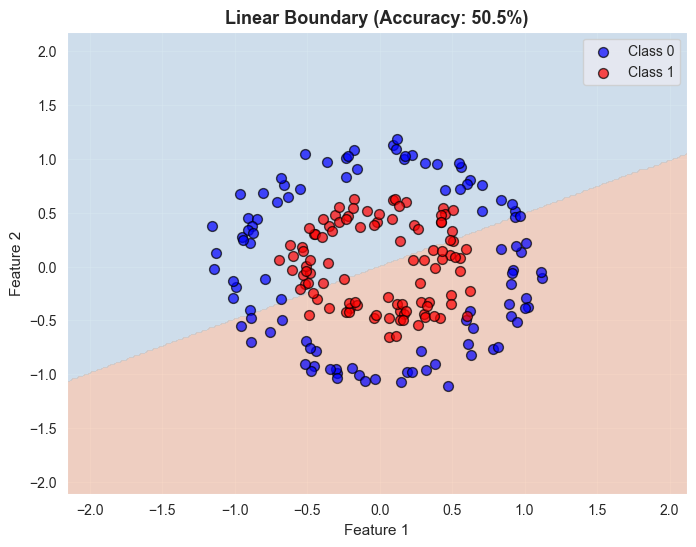

In [4]:
# Try linear logistic regression
X_circles_b = np.c_[np.ones((X_circles.shape[0], 1)), X_circles]
theta_circles_linear = np.zeros((3, 1))
theta_circles_linear, _ = gradient_descent(X_circles_b, y_circles, theta_circles_linear,
                                          learning_rate=0.1, n_iterations=5000, verbose=False)

# Evaluate
y_pred_linear = predict(X_circles_b, theta_circles_linear)
accuracy_linear = np.mean(y_circles == y_pred_linear)
print(f'Linear Model Accuracy: {accuracy_linear * 100:.2f}%')

plt.figure(figsize=(8, 6))
plot_decision_boundary(X_circles, y_circles, theta_circles_linear, 
                      f'Linear Boundary (Accuracy: {accuracy_linear*100:.1f}%)')
plt.show()


### Add Polynomial Features

Transform: $(x_1, x_2) \to (1, x_1, x_2, x_1^2, x_1 x_2, x_2^2)$

Now the decision boundary can be a **circle**!

Original features: (200, 2)
With polynomial features: (200, 6)
New features: [1, x1, x2, x1^2, x1*x2, x2^2]



Polynomial Model Accuracy: 99.00%


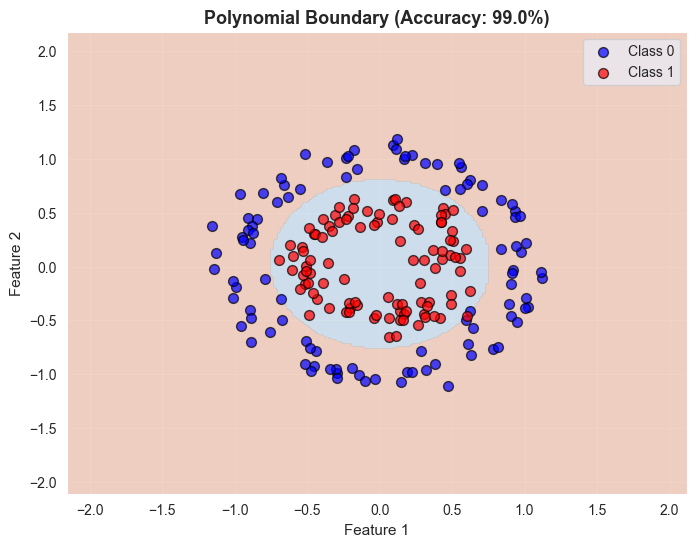

In [5]:
def create_poly_features(X, degree=2):
    """
    Create polynomial features up to specified degree.
    Includes bias term.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    return poly.fit_transform(X)

# Create polynomial features
X_circles_poly = create_poly_features(X_circles, degree=2)
print(f'Original features: {X_circles.shape}')
print(f'With polynomial features: {X_circles_poly.shape}')
print(f'New features: [1, x1, x2, x1^2, x1*x2, x2^2]')

# Train with polynomial features
theta_circles_poly = np.zeros((X_circles_poly.shape[1], 1))
theta_circles_poly, cost_hist = gradient_descent(X_circles_poly, y_circles, theta_circles_poly,
                                                learning_rate=0.1, n_iterations=10000, verbose=False)

# Evaluate
y_pred_poly = predict(X_circles_poly, theta_circles_poly)
accuracy_poly = np.mean(y_circles == y_pred_poly)
print(f'\nPolynomial Model Accuracy: {accuracy_poly * 100:.2f}%')

plt.figure(figsize=(8, 6))
plot_decision_boundary(X_circles, y_circles, theta_circles_poly,
                      f'Polynomial Boundary (Accuracy: {accuracy_poly*100:.1f}%)')
plt.show()


---
## Scenario 3: Moon-Shaped Data

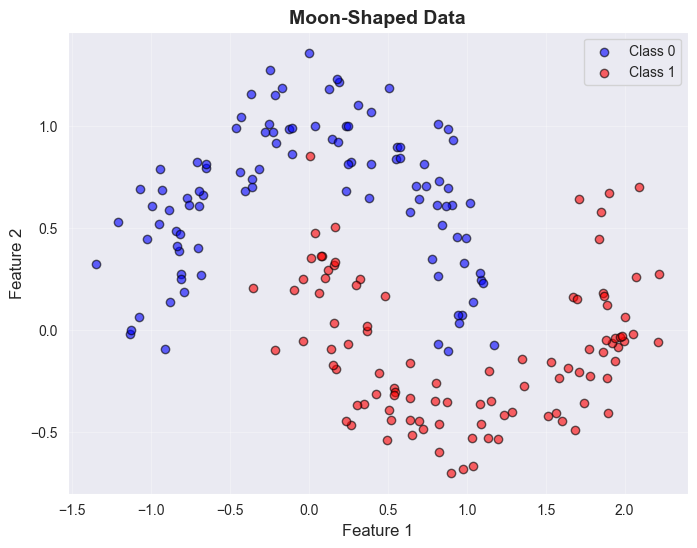

In [6]:
# Generate moon data
X_moons, y_moons = make_moons(n_samples=200, noise=0.15, random_state=42)
y_moons = y_moons.reshape(-1, 1)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[y_moons.ravel() == 0, 0], X_moons[y_moons.ravel() == 0, 1],
           c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(X_moons[y_moons.ravel() == 1, 0], X_moons[y_moons.ravel() == 1, 1],
           c='red', label='Class 1', alpha=0.6, edgecolors='k')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Moon-Shaped Data', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


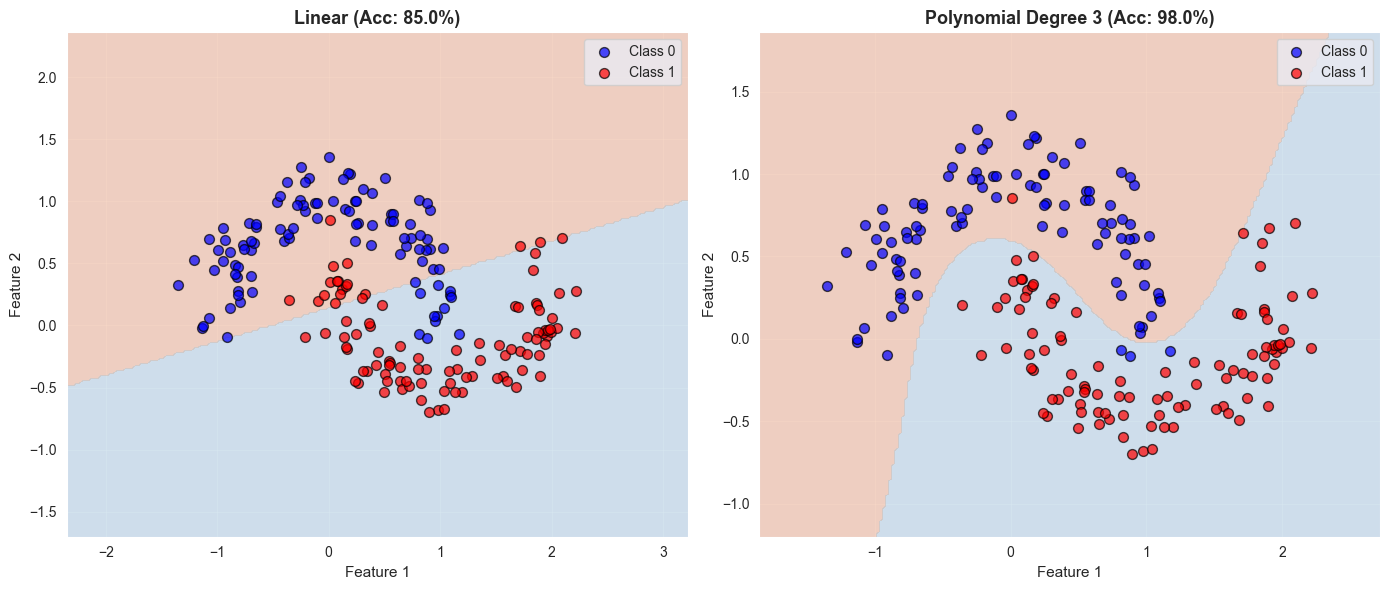

Linear Accuracy: 85.00%
Polynomial Accuracy: 98.00%


In [7]:
# Compare linear vs polynomial
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear
X_moons_b = np.c_[np.ones((X_moons.shape[0], 1)), X_moons]
theta_moons_linear = np.zeros((3, 1))
theta_moons_linear, _ = gradient_descent(X_moons_b, y_moons, theta_moons_linear,
                                        learning_rate=0.1, n_iterations=5000, verbose=False)
y_pred_linear = predict(X_moons_b, theta_moons_linear)
acc_linear = np.mean(y_moons == y_pred_linear)

plt.sca(axes[0])
plot_decision_boundary(X_moons, y_moons, theta_moons_linear,
                      f'Linear (Acc: {acc_linear*100:.1f}%)')

# Polynomial
X_moons_poly = create_poly_features(X_moons, degree=3)
theta_moons_poly = np.zeros((X_moons_poly.shape[1], 1))
theta_moons_poly, _ = gradient_descent(X_moons_poly, y_moons, theta_moons_poly,
                                      learning_rate=0.05, n_iterations=10000, verbose=False)
y_pred_poly = predict(X_moons_poly, theta_moons_poly)
acc_poly = np.mean(y_moons == y_pred_poly)

# For polynomial boundary visualization
x1_min, x1_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
x2_min, x2_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                      np.linspace(x2_min, x2_max, 200))
mesh_poly = create_poly_features(np.c_[xx1.ravel(), xx2.ravel()], degree=3)
Z_poly = predict(mesh_poly, theta_moons_poly).reshape(xx1.shape)

plt.sca(axes[1])
plt.contourf(xx1, xx2, Z_poly, alpha=0.3, cmap='RdYlBu', levels=[0, 0.5, 1])
plt.scatter(X_moons[y_moons.ravel() == 0, 0], X_moons[y_moons.ravel() == 0, 1],
           c='blue', label='Class 0', alpha=0.7, edgecolors='k', s=50)
plt.scatter(X_moons[y_moons.ravel() == 1, 0], X_moons[y_moons.ravel() == 1, 1],
           c='red', label='Class 1', alpha=0.7, edgecolors='k', s=50)
plt.xlabel('Feature 1', fontsize=11)
plt.ylabel('Feature 2', fontsize=11)
plt.title(f'Polynomial Degree 3 (Acc: {acc_poly*100:.1f}%)', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Linear Accuracy: {acc_linear*100:.2f}%')
print(f'Polynomial Accuracy: {acc_poly*100:.2f}%')


---
## Key Insights

### Linear Decision Boundaries
- Work well for **linearly separable** data
- Equation: $\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0$
- Fast to train, interpretable

### Non-Linear Decision Boundaries
- Required for complex patterns (circles, moons, etc.)
- Achieved by adding **polynomial features**
- Higher degree → more complex boundaries
- **Caution**: Too high degree → overfitting!

### Trade-offs
- **Linear**: Simple, fast, interpretable, but limited expressiveness
- **Polynomial**: Flexible, powerful, but risk of overfitting
- **Solution**: Use regularization (Ridge/Lasso) to control complexity

### When to Use What?
- **Linear**: When data is roughly linearly separable
- **Polynomial (degree 2-3)**: When you see curved patterns
- **Higher degrees or Neural Networks**: Very complex non-linear patterns

---

**Interview Question**: "How would you handle non-linearly separable data in logistic regression?"

**Answer**: "Add polynomial or interaction features to transform the feature space, making it linearly separable in the higher-dimensional space. However, I'd be careful about overfitting and would use regularization or cross-validation to choose the right polynomial degree."